### Checking SMAP datasets

In [1]:
%pwd

'/home/ubuntu/swe_forecasting_prod/contributors/bonan'

In [2]:
import pandas as pd 
import numpy as np
import geopandas as gp
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
predicted_swd= '/home/ubuntu/gridmet_test_run/test_data_predicted.csv'

In [7]:
testing_data = pd.read_csv("/home/ubuntu/gridmet_test_run/smap_testing.csv")
pre_testing = pd.read_csv(predicted_swd)

(784, 9)


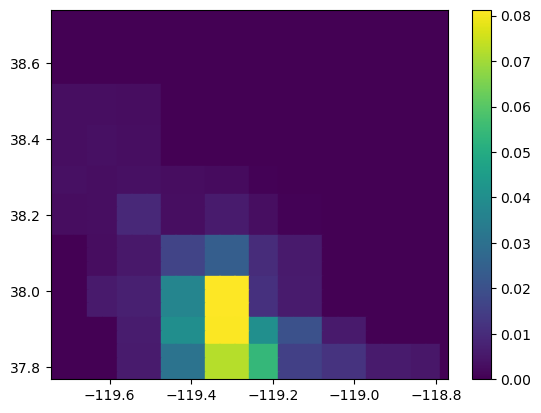

In [19]:
testing_example_date =testing_data[testing_data['date'] ==  '2018-04-15'].copy()
# print(testing_example_date["snow_mass"])
lat = testing_example_date['lat']
lon = testing_example_date['lon']
latlims = [np.min(lat),np.max(lat)]
lonlims = [np.min(lon),np.max(lon)]

fig, ax = plt.subplots()
out = ax.scatter(testing_example_date["lon"],
           testing_example_date["lat"],
           120,c=testing_example_date["snow_depth"],
           marker='s', cmap = "viridis")
ax.set_xlim(lonlims)
ax.set_ylim(latlims)
fig.colorbar(out)